In [1]:
import json
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

c:\users\surabhi\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
with open('uiuc.json') as json_file:
    data = json.load(json_file)['data']
print(len(data[0].keys()), data[0].keys())
columnnames = list(data[0].keys())
columnnames.sort()

28 dict_keys(['Target_Major', 'TOEFL_Speaking', 'Publications', 'Term', 'GRE_V', 'Work_Experience', 'Old_System', 'Topper_Grade', 'Status', 'TOEFL_Listening', 'Specialization', 'College_Affiliation', 'Grade_Scale', 'Program', 'Student_Id', 'TOEFL_Reading', 'TOEFL_Writing', 'GRE_AWA', 'IELTS', 'University', 'Undergrad_Major', 'Year', 'S.No', 'TOEFL', 'Grade', 'College_Main_Form', 'GRE_Total', 'GRE_Q'])


In [3]:
df = pd.DataFrame(data)

In [4]:
df.shape

(3947, 28)

# Data Cleaning

In [5]:
df.replace(-1, np.nan, inplace=True)
df.replace("-1", np.nan, inplace=True)

In [6]:
rows, cols = df.shape[0], df.shape[1]

In [7]:
infotoremovecol = list(rows - df.isna().sum())
canremove = np.argsort(infotoremovecol)

Text(0, 0.5, 'Number of rows with missing data, out of 3947')

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[3.36700337e-02 0.00000000e+00 4.54545455e-02]
 [0.00000000e+00 2.30324527e-04 4.54545455e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8    0.    53.45]
 [  0.   217.44  38.2 ]
 [  0.     0.     1.  ]]


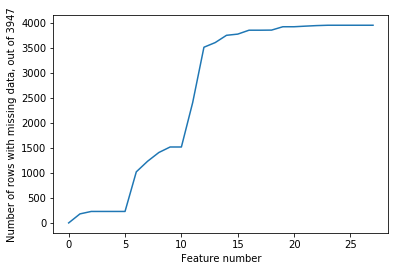

In [8]:
temp = infotoremovecol
temp.sort()
temp
plt.plot(temp)
plt.xlabel("Feature number")
plt.ylabel("Number of rows with missing data, out of 3947")

In [9]:
columnnames = np.array(columnnames)
todrop = columnnames[canremove[0:7]]
remaining = columnnames[canremove[7:]]
remaining.sort()

In [10]:
df.drop(todrop, axis=1, inplace=True)
df.drop("Old_System", axis=1, inplace=True)
df.drop("University", axis=1, inplace=True)
df.drop("Student_Id", axis=1, inplace=True)
df.drop("S.No", axis=1, inplace=True)
df.drop("College_Affiliation", axis=1, inplace=True)

In [11]:
df.dropna(how='any', inplace=True)

In [12]:
df.shape

(1056, 16)

In [13]:
df.columns

Index(['College_Main_Form', 'GRE_AWA', 'GRE_Q', 'GRE_Total', 'GRE_V', 'Grade',
       'Grade_Scale', 'Program', 'Publications', 'Status', 'TOEFL',
       'Target_Major', 'Term', 'Undergrad_Major', 'Work_Experience', 'Year'],
      dtype='object')

In [14]:
df["College_Main_Form"] = df["College_Main_Form"].astype('category')
df["College_Main_Form_Cat"] = df["College_Main_Form"].cat.codes

df["Program"] = df["Program"].astype('category')
df["Program_Cat"] = df["Program"].cat.codes

df["Status"] = df["Status"].astype('category')
df["Status_Cat"] = df["Status"].cat.codes

df["Target_Major"] = df["Target_Major"].astype('category')
df["Target_Major_Cat"] = df["Target_Major"].cat.codes

df["Term"] = df["Term"].astype('category')
df["Term_Cat"] = df["Term"].cat.codes

df["Undergrad_Major"] = df["Undergrad_Major"].astype('category')
df["Undergraduate_Major_Cat"] = df["Undergrad_Major"].cat.codes

df.insert(5, "Normalized_Grade", df[['Grade']].div(df.Grade_Scale, axis=0).values, True) 
df.drop('Grade', axis=1, inplace=True)
df.drop('Grade_Scale', axis=1, inplace=True)

# Analysis

In [15]:
x = df.describe()

In [16]:
x.iloc[[1,2,3,7],:]

,GRE_AWA,GRE_Q,GRE_Total,GRE_V,Normalized_Grade,Publications,TOEFL,Work_Experience,College_Main_Form_Cat,Program_Cat,Status_Cat,Target_Major_Cat,Term_Cat,Undergraduate_Major_Cat
mean,3.861742,164.444129,322.091856,157.642992,0.819466,0.164773,109.64678,4.569129,84.226326,1.089962,0.768939,10.936553,0.064394,13.882576
std,0.593659,3.475398,7.473307,5.961679,0.094418,0.662703,6.10937,11.923490,50.533241,0.469399,0.421711,5.284400,0.260552,6.235158
min,2.500000,148.000000,295.000000,140.000000,0.370000,0.000000,85.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,170.000000,338.000000,170.000000,1.000000,7.000000,120.00000,76.000000,157.000000,3.000000,1.000000,23.000000,2.000000,30.000000


In [19]:
print("Number of students =", df.shape[0])

Number of students = 1056


c:\users\surabhi\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


[[7.97142857e+01 0.00000000e+00 2.59714286e+02]
 [0.00000000e+00 7.76571429e+01 1.18954286e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 3.39428571e+02]
 [0.00000000e+00 7.76571429e+01 1.18954286e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 4.19142857e+02]
 [0.00000000e+00 7.76571429e+01 1.18954286e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 4.98857143e+02]
 [0.00000000e+00 7.76571429e+01 1.18954286e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 5.78571429e+02]
 [0.00000000e+00 7.76571429e+01 1.189542

[[ 79.71428571   0.         817.71428571]
 [  0.          77.65714286 956.57142857]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 79.71428571   0.         897.42857143]
 [  0.          77.65714286 956.57142857]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 79.71428571   0.         977.14285714]
 [  0.          77.65714286 956.57142857]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.05685714e+03]
 [0.00000000e+00 7.76571429e+01 9.56571429e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.13657143e+03]
 [0.00000000e+00 7.76571429e+01 9.56571429e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00

[[ 79.71428571   0.         897.42857143]
 [  0.          77.65714286 723.6       ]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 79.71428571   0.         977.14285714]
 [  0.          77.65714286 723.6       ]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.05685714e+03]
 [0.00000000e+00 7.76571429e+01 7.23600000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.13657143e+03]
 [0.00000000e+00 7.76571429e+01 7.23600000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.21628571e+03]
 [0.00000000e+00 7.76571429e+01 7.23600000e+02]
 [0.00000000e+00 0.00000000e

[[ 79.71428571   0.         817.71428571]
 [  0.          77.65714286 412.97142857]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 79.71428571   0.         897.42857143]
 [  0.          77.65714286 412.97142857]
 [  0.           0.           1.        ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.05685714e+03]
 [0.00000000e+00 7.76571429e+01 4.12971429e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.13657143e+03]
 [0.00000000e+00 7.76571429e+01 4.12971429e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[7.97142857e+01 0.00000000e+00 1.21628571e+03]
 [0.00000000e+00 7.76571429e+01 4.12971429e+02]
 [0.00000000e+00 0.00000000e

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024852851278>,
      dtype=object)

[[7.97142857e+01 0.00000000e+00 1.80000000e+02]
 [0.00000000e+00 7.76571429e+01 1.18954286e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          0.00238692 -0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          0.04329004 -6.38311688]
 [ 0.          0.          1.        ]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          0.02214839 -6.50996678]
 [ 0.          0.          1.        ]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          0.03174603 -4.42063492]
 [ 0.          0.          1.        ]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          1.5117158  -0.53552532]
 [ 0.          0.          1.        ]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          0.13605442  0.02380952]
 [ 0.          0.          1.        ]]
[[ 0.27210884  0.         -0.65646259]
 [ 0.          0.02721088 -2.28911565]
 [ 0.          0.          1.   

[[ 79.71428571   0.          46.85625   ]
 [  0.          77.65714286 199.67053571]
 [  0.           0.           1.        ]]
[[ 79.71428571   0.          46.85625   ]
 [  0.          77.65714286 122.01339286]
 [  0.           0.           1.        ]]
[[79.71428571  0.         46.85625   ]
 [ 0.         77.65714286 44.35625   ]
 [ 0.          0.          1.        ]]
[[ 79.71428571   0.         126.57053571]
 [  0.          77.65714286  44.35625   ]
 [  0.           0.           1.        ]]
[[ 79.71428571   0.         206.28482143]
 [  0.          77.65714286  44.35625   ]
 [  0.           0.           1.        ]]
[[ 79.71428571   0.         285.99910714]
 [  0.          77.65714286  44.35625   ]
 [  0.           0.           1.        ]]
[[ 79.71428571   0.         365.71339286]
 [  0.          77.65714286  44.35625   ]
 [  0.           0.           1.        ]]
[[ 79.71428571   0.         445.42767857]
 [  0.          77.65714286  44.35625   ]
 [  0.           0.           1.    

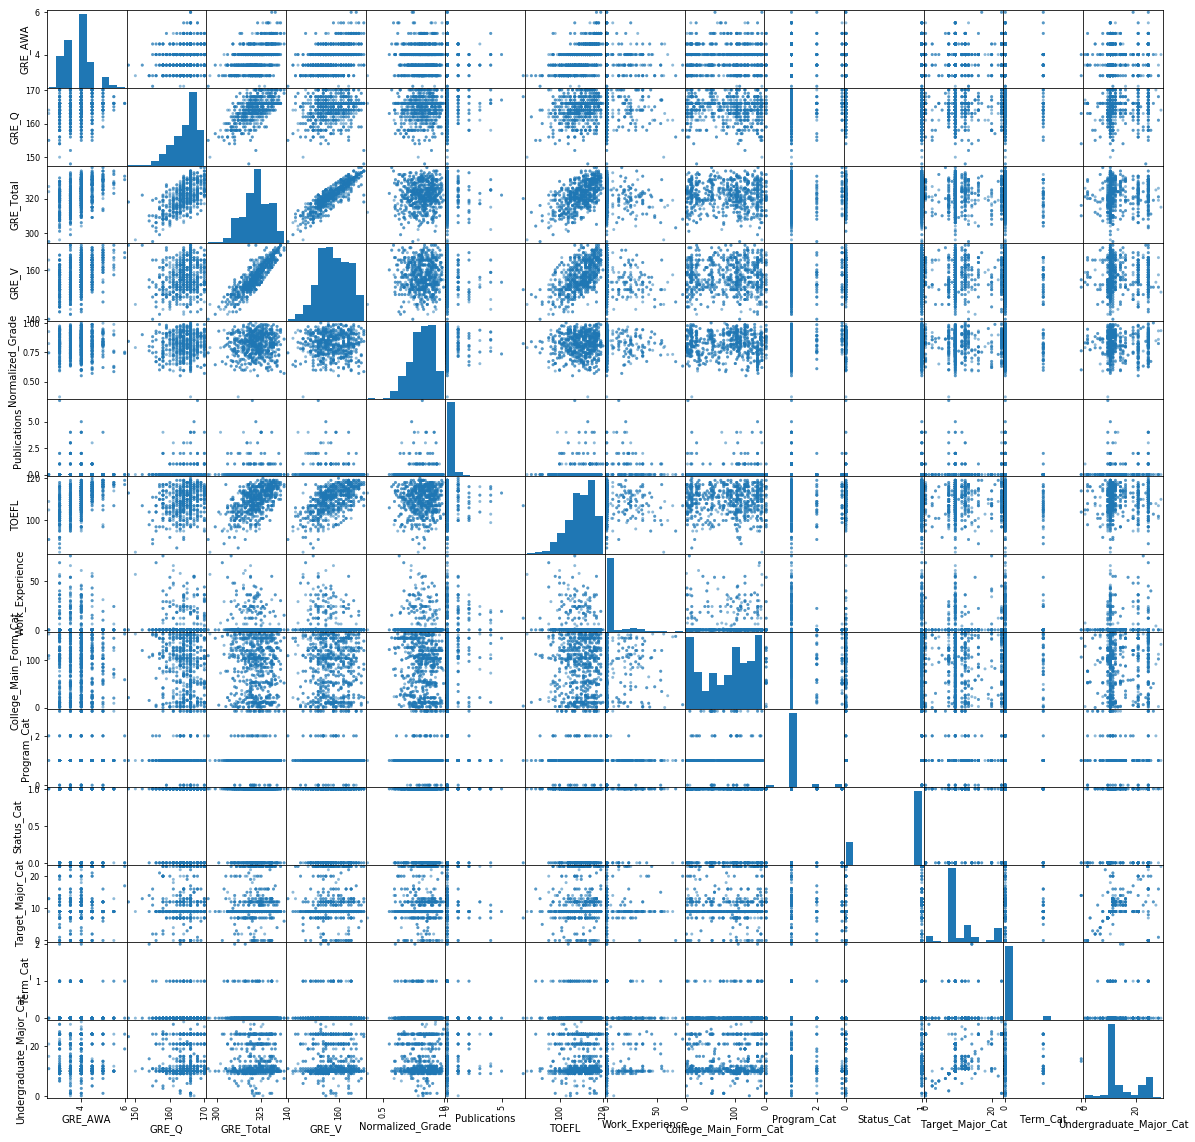

In [20]:
pd.scatter_matrix(df, figsize=(20, 20))

<Figure size 432x288 with 0 Axes>

[[223.2    0.    43.2 ]
 [  0.   223.2   25.92]
 [  0.     0.     1.  ]]
[[ 0.07142857  0.          0.03571429]
 [ 0.         -0.07142857  0.96428571]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[223.2    0.    26.95]
 [  0.   223.2   10.7 ]
 [  0.     0.     1.  ]]


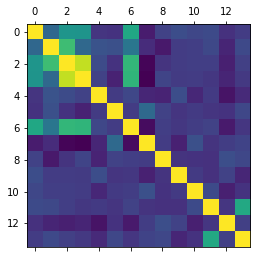

In [21]:
plt.figure()
corr = df.corr()
plt.matshow(corr)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
plt.show()

In [22]:
admit = df.loc[df['Status'] == 'Admit']
reject = df.loc[df['Status'] == 'Reject']
num_admits, num_rejects, num_total = len(admit), len(reject), len(admit) + len(reject)

Number of Admits 244 
Number of Rejects 812 
Total Number of Applicants 1056
ACCEPTANCE STATISTICS
Probability Accept = 0.23106060606060605
Probability Reject = 0.7689393939393939
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[0.29406327 0.         0.50058677]
 [0.         0.45277954 0.50049915]
 [0.         0.         1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    10.7 ]
 [  0.   217.44  10.7 ]
 [  0.     0.     1.  ]]


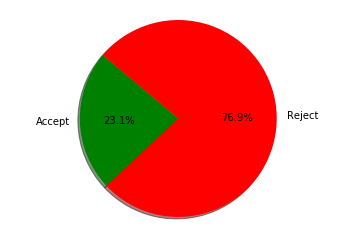

In [23]:
print("Number of Admits", num_admits, "\nNumber of Rejects", num_rejects, "\nTotal Number of Applicants", num_total)
assert num_admits + num_rejects == num_total
print("ACCEPTANCE STATISTICS")
print("Probability Accept =", num_admits/num_total)
print("Probability Reject =", num_rejects/num_total)

# Pie Chart
labels = 'Accept', 'Reject'
sizes = [num_admits, num_rejects]
colors = ['green', 'red']
explode = (0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [24]:
status = df.groupby("Status")
for name, group in status:
    print(name)
    print(group.describe())

Admit
          GRE_AWA       GRE_Q   GRE_Total       GRE_V  Normalized_Grade  \
count  244.000000  244.000000  244.000000  244.000000        244.000000   
mean     3.805328  164.323770  321.852459  157.528689          0.831357   
std      0.621968    3.454241    7.419995    5.638200          0.100028   
min      3.000000  154.000000  301.000000  145.000000          0.370000   
25%      3.500000  163.000000  317.000000  154.000000          0.771000   
50%      4.000000  165.000000  322.000000  157.000000          0.850500   
75%      4.000000  166.000000  327.000000  162.000000          0.912625   
max      6.000000  170.000000  338.000000  170.000000          0.987500   

       Publications       TOEFL  Work_Experience  College_Main_Form_Cat  \
count    244.000000  244.000000       244.000000             244.000000   
mean       0.163934  109.487705         2.590164              87.073770   
std        0.784213    5.575137         9.980849              48.114861   
min        0.00000

# Accepted vs Rejected GRE

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mean Accept 321.8524590163934 
Mean Reject 322.16379310344826 \St. dev Accept 7.404774856438908 
St dev Reject 7.487692324827623


Text(0, 0.5, 'GRE Total Score, out of 340')

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 3.74111485e-03  0.00000000e+00  4.54545455e-02]
 [ 0.00000000e+00  2.45700246e-02 -7.35012285e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 1.12095057e-03  0.00000000e+00  4.54545455e-02]
 [ 0.00000000e+00  2.11416490e-02 -6.19133192e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8    0.    47.2 ]
 [  0.   217.44  38.2 ]
 [  0.     0.     1.  ]]


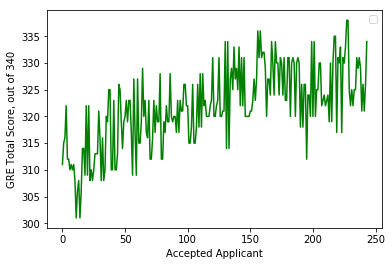

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8     0.     47.075]
 [  0.    217.44   38.2  ]
 [  0.      0.      1.   ]]


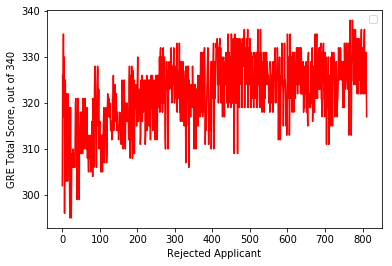

In [25]:
mean1 = np.mean(list(admit['GRE_Total']))
mean2 = np.mean(list(reject['GRE_Total']))
dev1 = np.sqrt(np.var(list(admit['GRE_Total'])))
dev2 = np.sqrt(np.var(list(reject['GRE_Total'])))
print("Mean Accept", mean1, "\nMean Reject", mean2, "\St. dev Accept", dev1, "\nSt dev Reject", dev2)

plt.figure()
plt.plot(list(admit['GRE_Total']), color="Green")
plt.legend()
plt.xlabel("Accepted Applicant")
plt.ylabel("GRE Total Score, out of 340")

plt.figure()
plt.plot(list(reject['GRE_Total']), color="Red")
plt.legend()
plt.xlabel("Rejected Applicant")
plt.ylabel("GRE Total Score, out of 340")

# Accepted vs Rejected TOEFL

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mean Accept 109.48770491803279 
Mean Reject 109.69458128078817 \St. dev Accept 5.563700824428494 
St dev Reject 6.259599146504553


Text(0, 0.5, 'TOEFL Total Score, out of 120')

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 0.00374111  0.          0.04545455]
 [ 0.          0.03787879 -3.5530303 ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 1.12095057e-03  0.00000000e+00  4.54545455e-02]
 [ 0.00000000e+00  2.59740260e-02 -2.16233766e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8     0.     47.325]
 [  0.    217.44   38.2  ]
 [  0.      0.      1.   ]]


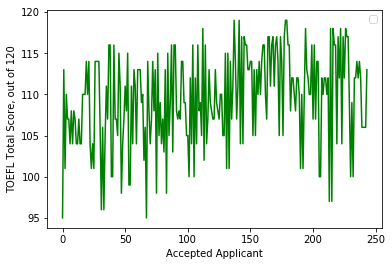

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8     0.     47.325]
 [  0.    217.44   38.2  ]
 [  0.      0.      1.   ]]


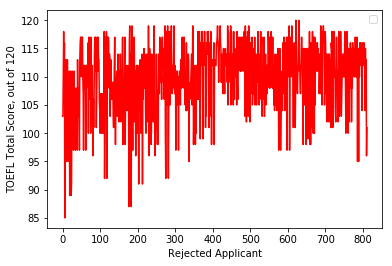

In [26]:
mean1 = np.mean(list(admit['TOEFL']))
mean2 = np.mean(list(reject['TOEFL']))
dev1 = np.sqrt(np.var(list(admit['TOEFL'])))
dev2 = np.sqrt(np.var(list(reject['TOEFL'])))
print("Mean Accept", mean1, "\nMean Reject", mean2, "\St. dev Accept", dev1, "\nSt dev Reject", dev2)

plt.figure()
plt.plot(list(admit['TOEFL']), color="Green")
plt.legend()
plt.xlabel("Accepted Applicant")
plt.ylabel("TOEFL Total Score, out of 120")

plt.figure()
plt.plot(list(reject['TOEFL']), color="Red")
plt.legend()
plt.xlabel("Rejected Applicant")
plt.ylabel("TOEFL Total Score, out of 120")

[[558.    0.   90. ]
 [  0.  271.8  45. ]
 [  0.    0.    1. ]]
[[ 0.03225806  0.          0.01612903]
 [ 0.          0.01147447 -0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[558.      0.     40.825]
 [  0.    271.8    56.825]
 [  0.      0.      1.   ]]


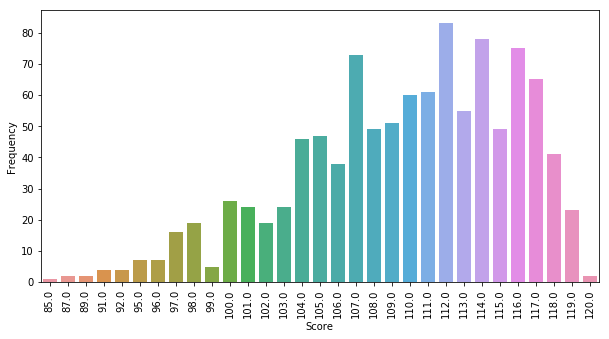

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(x=df.TOEFL.value_counts().index, y=df.TOEFL.value_counts().values)
plt.xticks(rotation=90)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Grade

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 1.472212    0.         -0.49926389]
 [ 0.          0.01253133 -0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 2.02020202  0.         -1.06565657]
 [ 0.          0.00647878 -0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8     0.     26.825]
 [  0.    217.44   24.2  ]
 [  0.      0.      1.   ]]


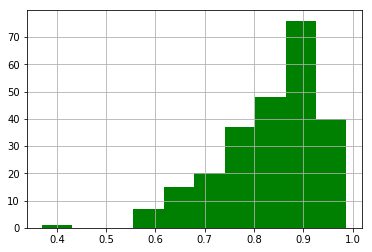

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8    0.    33.2 ]
 [  0.   217.44  24.2 ]
 [  0.     0.     1.  ]]


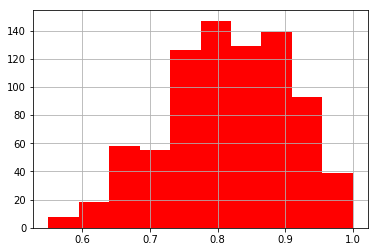

In [28]:
df[df.Status=='Admit'].Normalized_Grade.hist(color="green")
plt.figure()
df[df.Status=='Reject'].Normalized_Grade.hist(color="red")

# Other

[[279.    0.   45. ]
 [  0.  271.8  45. ]
 [  0.    0.    1. ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[360.   0.   0.]
 [  0. 360.   0.]
 [  0.   0.   1.]]
[[307.5875   0.      33.675 ]
 [  0.     317.4     27.8   ]
 [  0.       0.       1.    ]]
[[1.79173247 0.         0.5       ]
 [0.         0.11300412 0.10448558]
 [0.         0.         1.        ]]
[[0.54973462 0.         0.18491698]
 [0.         0.11300412 0.10448558]
 [0.         0.         1.        ]]
[[0.5        0.         0.25      ]
 [0.         0.11300412 0.10448558]
 [0.         0.         1.        ]]


[[307.525   0.     38.175]
 [  0.    303.9    41.8  ]
 [  0.      0.      1.   ]]
[[307.525   0.     38.175]
 [  0.    303.9    41.8  ]
 [  0.      0.      1.   ]]
[[307.525   0.     34.575]
 [  0.    303.9    38.2  ]
 [  0.      0.      1.   ]]


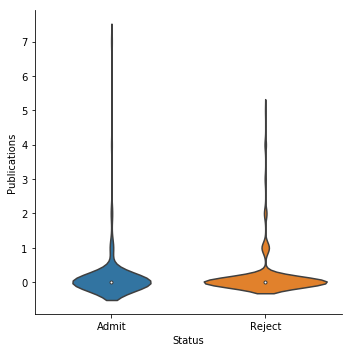

In [29]:
sns.catplot(x="Status", y="Publications", kind='violin', data=df)

[[279.    0.   45. ]
 [  0.  271.8  45. ]
 [  0.    0.    1. ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[360.   0.   0.]
 [  0. 360.   0.]
 [  0.   0.   1.]]
[[307.5875   0.      33.675 ]
 [  0.     317.4     27.8   ]
 [  0.       0.       1.    ]]
[[ 1.13636364  0.          0.5       ]
 [ 0.          1.2108926  -0.32189335]
 [ 0.          0.          1.        ]]
[[ 0.51464171  0.          0.25131123]
 [ 0.          1.2108926  -0.32189335]
 [ 0.          0.          1.        ]]
[[ 0.5         0.          0.25      ]
 [ 0.          1.2108926  -0.32189335]
 [ 0.          0.          1.        ]]


[[297.11875   0.       48.58125]
 [  0.      303.9      41.8    ]
 [  0.        0.        1.     ]]
[[297.11875   0.       48.58125]
 [  0.      303.9      41.8    ]
 [  0.        0.        1.     ]]
[[297.11875   0.       44.98125]
 [  0.      303.9      38.2    ]
 [  0.        0.        1.     ]]


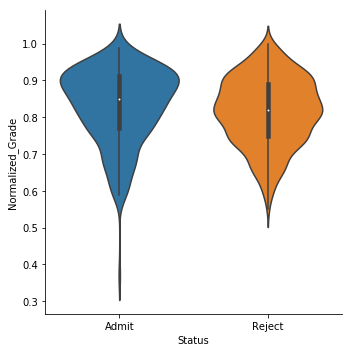

In [30]:
sns.catplot(x="Status", y="Normalized_Grade", kind='violin', data=df)

[[279.    0.   45. ]
 [  0.  271.8  45. ]
 [  0.    0.    1. ]]
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[360.   0.   0.]
 [  0. 360.   0.]
 [  0.   0.   1.]]
[[307.5875   0.      33.675 ]
 [  0.     317.4     27.8   ]
 [  0.       0.       1.    ]]
[[1.13636364 0.         0.5       ]
 [0.         0.01018055 0.11313926]
 [0.         0.         1.        ]]
[[0.51182652 0.         0.25018515]
 [0.         0.01018055 0.11313926]
 [0.         0.         1.        ]]
[[0.5        0.         0.25      ]
 [0.         0.01018055 0.11313926]
 [0.         0.         1.        ]]


[[300.36875   0.       45.33125]
 [  0.      303.9      41.8    ]
 [  0.        0.        1.     ]]
[[300.36875   0.       45.33125]
 [  0.      303.9      41.8    ]
 [  0.        0.        1.     ]]
[[300.36875   0.       41.73125]
 [  0.      303.9      38.2    ]
 [  0.        0.        1.     ]]


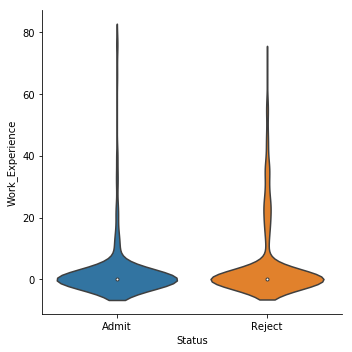

In [31]:
sns.catplot(x="Status", y="Work_Experience", kind='violin', data=df)

# Classifiers

In [32]:
def plot_roc(false_positive_rate, true_positive_rate, roc_auc):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_feature_importances(model, X_train, labels):
    n_features=X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), labels=labels)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

In [33]:
df

,College_Main_Form,GRE_AWA,GRE_Q,GRE_Total,GRE_V,Normalized_Grade,Program,Publications,Status,TOEFL,...,Term,Undergrad_Major,Work_Experience,Year,College_Main_Form_Cat,Program_Cat,Status_Cat,Target_Major_Cat,Term_Cat,Undergraduate_Major_Cat
2433,Keshav Memorial Institute of Technology,3.5,158.0,302.0,144.0,0.7887,MS,4.0,Reject,103.0,...,Fall,ENI,7.0,2014,73,1,1,9,0,13
2434,Anna University,3.5,167.0,326.0,159.0,0.7900,MS,1.0,Reject,103.0,...,Fall,Aeronautical Engineering,7.0,2015,2,1,1,0,0,0
2436,Bangalore University,4.0,162.0,311.0,149.0,0.8500,MS,0.0,Admit,95.0,...,Fall,Information Science and Engineering,6.0,2014,13,1,0,9,0,19
2437,University of Pune,4.0,162.0,322.0,160.0,0.7373,MS,1.0,Reject,110.0,...,Fall,Civil Engineering,6.0,2014,148,1,1,7,0,9
2438,Maharshi Dayanand University,3.5,163.0,315.0,152.0,0.9125,MS,0.0,Admit,113.0,...,Fall,ECE,6.0,2015,82,1,0,14,0,11
2439,NIT Raipur,3.0,164.0,316.0,152.0,0.7790,MS,0.0,Admit,101.0,...,Fall,Information Technology,6.0,2015,99,1,0,20,0,21
2441,NIT Raipur,4.0,167.0,322.0,155.0,0.8010,MS,0.0,Admit,110.0,...,Fall,Information Technology,6.0,2015,99,1,0,20,0,21
2442,Jadavpur University,5.5,168.0,335.0,167.0,0.9330,PhD,0.0,Reject,118.0,...,Fall,Computer Science,6.0,2012,64,3,1,9,0,10
2443,The Northcap University,4.0,168.0,317.0,149.0,0.9010,MS,1.0,Reject,107.0,...,Fall,Computer Science,6.0,2015,142,1,1,9,0,10
2444,"BITS Pilani, Pilani Campus",4.5,169.0,330.0,161.0,0.7890,MS,0.0,Reject,116.0,...,Fall,Civil Engineering,6.0,2015,11,1,1,7,0,9


In [34]:
df.drop('College_Main_Form', axis=1, inplace=True)
df.drop('Program', axis=1, inplace=True)
df.drop('Status', axis=1, inplace=True)
df.drop('Target_Major', axis=1, inplace=True)
df.drop('Term', axis=1, inplace=True)
df.drop('Undergrad_Major', axis=1, inplace=True)

In [35]:
print(df.shape)
num_rows = df.shape[0]
num_cols = df.shape[1]

(1056, 15)


In [36]:
colnames = list(df.columns)

In [37]:
indices = []
indices_cols = []
for i in range(num_cols):
    if i == 11:
        continue
    indices.append(i)
    indices_cols.append(colnames[i])

In [38]:
data_X = df.iloc[0:len(df), indices]
data_Y = df['Status_Cat']

print(data_X.shape, data_Y.shape)

(1056, 14) (1056,)


In [39]:
X_train, X_test, Y_train, Y_test=train_test_split(data_X, data_Y, test_size=0.2)
X_train, X_test, Y_train, Y_test=np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)

X_train=preprocessing.scale(X_train)
X_test=preprocessing.scale(X_test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(844, 14) (212, 14) (844,) (212,)


c:\users\surabhi\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


0.7405660377358491
             precision    recall  f1-score   support

          0       0.71      0.09      0.15        58
          1       0.74      0.99      0.85       154

avg / total       0.73      0.74      0.66       212

0.7796208530805687
             precision    recall  f1-score   support

          0       0.50      0.03      0.05       186
          1       0.78      0.99      0.88       658

avg / total       0.72      0.78      0.69       844

[[72.  0.  0.]
 [ 0. 72.  0.]
 [ 0.  0.  1.]]
[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 0.5  0.  -0. ]
 [ 0.  -0.5  1. ]
 [ 0.   0.   1. ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[ 0.00666667  0.         -0.01333333]
 [ 0.          0.00666667 -0.01333333]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[267.84   0.    24.2 ]
 [  0.   217.44  24.2 ]
 [  0.     0.     1.  ]]
[[ 10.872   0.    308.78 ]
 [  0.    217.44   24.2  ]
 [  0.      0.      1.   ]]


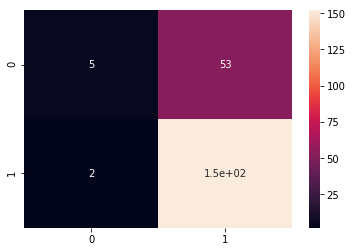

In [40]:
log_reg_classifier=LogisticRegression(solver='lbfgs', penalty='l2').fit(X_train, Y_train)
test_preds=log_reg_classifier.predict(X_test)
train_preds=log_reg_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

In [41]:
print(indices_cols)

['GRE_AWA', 'GRE_Q', 'GRE_Total', 'GRE_V', 'Normalized_Grade', 'Publications', 'TOEFL', 'Work_Experience', 'Year', 'College_Main_Form_Cat', 'Program_Cat', 'Target_Major_Cat', 'Term_Cat', 'Undergraduate_Major_Cat']


0.8443396226415094
             precision    recall  f1-score   support

          0       0.75      0.66      0.70        58
          1       0.88      0.92      0.90       154

avg / total       0.84      0.84      0.84       212

0.9549763033175356
             precision    recall  f1-score   support

          0       0.96      0.83      0.89       186
          1       0.95      0.99      0.97       658

avg / total       0.96      0.95      0.95       844

[[72.  0.  0.]
 [ 0. 72.  0.]
 [ 0.  0.  1.]]
[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 0.5  0.  -0. ]
 [ 0.  -0.5  1. ]
 [ 0.   0.   1. ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[ 0.0078125  0.        -0.1015625]
 [ 0.         0.0078125 -0.1015625]
 [ 0.         0.         1.       ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
['GRE_AWA', 'GRE_Q', 'GRE_Total', 'GRE_V', 'Normalized_Grade', 'Publications', 'TOEFL', 'Work

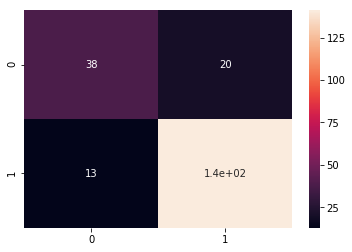

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8    0.   158.7 ]
 [  0.   217.44  38.2 ]
 [  0.     0.     1.  ]]


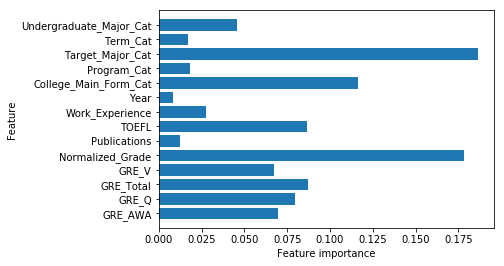

In [42]:
dt_classifier=DecisionTreeClassifier(max_depth=10).fit(X_train, Y_train)
test_preds=dt_classifier.predict(X_test)
train_preds=dt_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

plt.figure()
plot_feature_importances(dt_classifier, X_train, labels=list(data_X.columns))
print(indices_cols)

0.7264150943396226
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        58
          1       0.73      1.00      0.84       154

avg / total       0.53      0.73      0.61       212

0.7796208530805687
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       186
          1       0.78      1.00      0.88       658

avg / total       0.61      0.78      0.68       844

[[72.  0.  0.]
 [ 0. 72.  0.]
 [ 0.  0.  1.]]
[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 0.5  0.  -0. ]
 [ 0.  -0.5  1. ]
 [ 0.   0.   1. ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[ 0.00649351  0.         -0.        ]
 [ 0.          0.00649351 -0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 3.138145

c:\users\surabhi\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[267.84   0.    24.2 ]
 [  0.   217.44  24.2 ]
 [  0.     0.     1.  ]]
[[ 10.872   0.    308.78 ]
 [  0.    217.44   24.2  ]
 [  0.      0.      1.   ]]


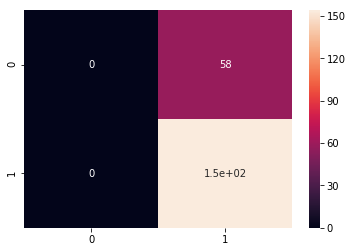

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8    0.   158.7 ]
 [  0.   217.44  38.2 ]
 [  0.     0.     1.  ]]


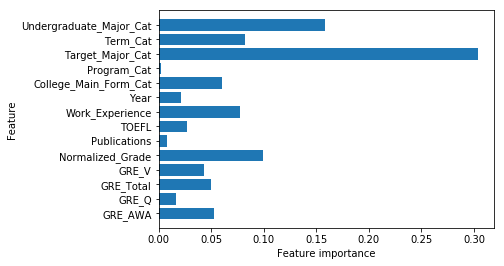

In [44]:
rf_classifier=RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, Y_train)
test_preds=rf_classifier.predict(X_test)
train_preds=rf_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

plt.figure()
plot_feature_importances(rf_classifier, X_train, labels=list(data_X.columns))

0.8726415094339622
             precision    recall  f1-score   support

          0       0.78      0.74      0.76        58
          1       0.90      0.92      0.91       154

avg / total       0.87      0.87      0.87       212

1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       186
          1       1.00      1.00      1.00       658

avg / total       1.00      1.00      1.00       844

[[72.  0.  0.]
 [ 0. 72.  0.]
 [ 0.  0.  1.]]
[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 0.5  0.  -0. ]
 [ 0.  -0.5  1. ]
 [ 0.   0.   1. ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[ 0.00769231  0.         -0.09230769]
 [ 0.          0.00769231 -0.09230769]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 4.12309224  0.         

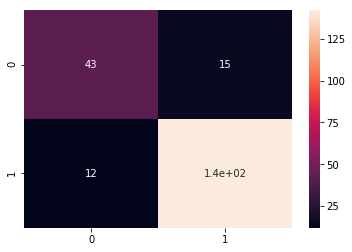

[[334.8    0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[334.8    0.   158.7 ]
 [  0.   217.44  38.2 ]
 [  0.     0.     1.  ]]


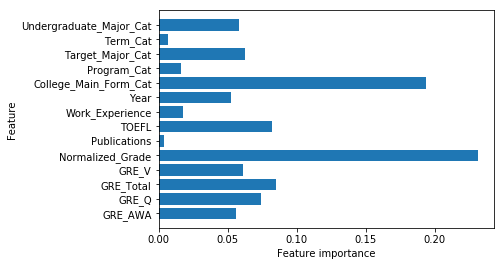

In [45]:
gbm_classifier=GradientBoostingClassifier(loss='exponential', n_estimators=1000).fit(X_train, Y_train)
test_preds=gbm_classifier.predict(X_test)
train_preds=gbm_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

plt.figure()
plot_feature_importances(gbm_classifier, X_train, labels=list(data_X.columns))

0.7547169811320755
             precision    recall  f1-score   support

          0       1.00      0.10      0.19        58
          1       0.75      1.00      0.86       154

avg / total       0.82      0.75      0.67       212

0.8317535545023697
             precision    recall  f1-score   support

          0       1.00      0.24      0.38       186
          1       0.82      1.00      0.90       658

avg / total       0.86      0.83      0.79       844

[[72.  0.  0.]
 [ 0. 72.  0.]
 [ 0.  0.  1.]]
[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 0.5  0.  -0. ]
 [ 0.  -0.5  1. ]
 [ 0.   0.   1. ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[ 0.00649351  0.         -0.        ]
 [ 0.          0.00649351 -0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


[[267.84   0.    54.  ]
 [  0.   217.44  36.  ]
 [  0.     0.     1.  ]]
[[ 10.872   0.    338.58 ]
 [  0.    217.44   36.   ]
 [  0.      0.      1.   ]]
[[267.84   0.    24.2 ]
 [  0.   217.44  24.2 ]
 [  0.     0.     1.  ]]
[[ 10.872   0.    308.78 ]
 [  0.    217.44   24.2  ]
 [  0.      0.      1.   ]]


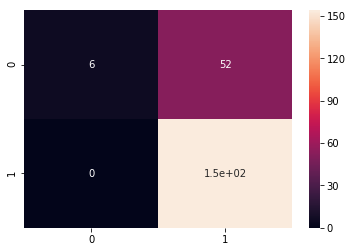

In [46]:
svm_classifier=SVC(gamma='auto', C=1).fit(X_train, Y_train)
test_preds=svm_classifier.predict(X_test)
train_preds=svm_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)